<a href="https://colab.research.google.com/github/chayan18/Neural-Network-using-Tensorflow/blob/master/1d_bar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install geomdl

     |████████████████████████████████| 147 kB 5.4 MB/s 


In [ ]:
import numpy as np
from geomdl import NURBS
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import matplotlib.patches as mpatches

class Geometry1D:
    '''
     Base class for 1D domains
     Input: geomData - dictionary containing the geomety information
     Keys: degree_u: polynomial degree in the u direction
       ctrlpts_size_u: number of control points in u direction
       ctrlpts: weighted control points (in a list with 
            ctrlpts_size_u rows and 3 columns for x,y,z coordinates)
       weights: correspond weights (list with ctrlpts_size_u*ctrlpts_size_v entries)
       knotvector_u: knot vectors in the u direction
    '''
    def __init__(self, geomData):
        self.curv = NURBS.Curve()
        self.curv.degree = geomData['degree_u']
#        self.curv.ctrlpts_size = geomData['ctrlpts_size_u']
        self.curv.ctrlpts = self.getUnweightedCpts(geomData['ctrlpts'], 
                                             geomData['weights'])
        self.curv.weights = geomData['weights']
        self.curv.knotvector = geomData['knotvector_u']

    def getUnweightedCpts(self, ctrlpts, weights):
        numCtrlPts = np.shape(ctrlpts)[0]
        PctrlPts = np.zeros_like(ctrlpts)
        for i in range(3):
            for j in range(numCtrlPts):
                PctrlPts[j,i]=ctrlpts[j][i]/weights[j]
        PctrlPts = PctrlPts.tolist()
        return PctrlPts
        
    def mapPoints(self, uPar):
        '''
        Map points from the parameter domain [0,1]x[0,1] to the quadrilater domain
        Input:  uPar - array containing the u-coordinates in the parameter space
        Output: xPhys - array containing the x-coordinates in the physical space
        '''        
        gpParamU = np.array([uPar])
        evalList = tuple(map(tuple, gpParamU.transpose()))
        res = np.array(self.curv.evaluate_list(evalList))
                
        return res
    
    def getUnifIntPts(self, numPtsU, withEdges):
        '''
        Generate uniformly spaced points inside the domain
        Input: numPtsU - number of points (including edges) in the u direction in the parameter space
               withEdges - 1x2 array of zeros or ones specifying whether the boundary points
                           should be included. The boundary order is [bottom, right,
                           top, left] for the unit square.
        Output: xM, yM - flattened array containing the x and y coordinates of the points
        '''
        #generate points in the x direction on the interval [0,1]
        uEdge = np.linspace(0, 1, numPtsU)
        
        #remove endpoints depending on values of withEdges
        if withEdges[0]==0:
            uEdge = uEdge[:-1]
        if withEdges[1]==0:
            uEdge = uEdge[1:]

        #map points
        res = self.mapPoints(uEdge.T)
        
        xPhys = res[:, 0:1]
        
        return xPhys
    
    def getIntPts(self, numElemU, numGauss):
        '''
        Generate quadrature points inside the domain
        Input: numElemU - number of subdivisions in the u 
                   direction in the parameter space
               numGauss - number of Gauss quadrature points for each subdivision
        Output: xPhys, wgtPhy - arrays containing the x coordinate
                                    of the points and the corresponding weights
        '''
        # Allocate quadPts array
        quadPts = np.zeros((numElemU*numGauss, 2))
        vertex = np.zeros((numElemU, 2))
        # Get the Gauss points on the reference interval [-1,1]
        gp, gw = np.polynomial.legendre.leggauss(numGauss)
        
        # Generate the knots on the interval [0,1]
        uEdge = np.linspace(0, 1, numElemU+1)
        uPar = uEdge              
                        
        # Generate points for each element
        indexPt = 0
        for iU in range(numElemU):
            uMin = uPar[iU]
            uMax = uPar[iU+1]
            vertex[iU,0] = uMin
            vertex[iU,1] = uMax
            gpParamU = (uMax-uMin)/2*gp+(uMax+uMin)/2
            # Jacobian of the transformation from the reference element [-1,1]
            scaleFac = (uMax-uMin)/2
            # Map the points to the physical space
            for iPt in range(numGauss):
                curPtU = gpParamU[iPt]
                derivMat = self.curv.derivatives(curPtU, order=1)
                physPtX = derivMat[0][0]
                derivU = derivMat[1][0:1]
                JacobMat = np.array([derivU])
                detJac = np.linalg.det(JacobMat)
                quadPts[indexPt, 0] = physPtX
                quadPts[indexPt, 1] = scaleFac * detJac * gw[iPt]
                indexPt = indexPt + 1
                            
        xPhys = quadPts[:, 0:1]
        wgtPhys = quadPts[:, 1:2]

        return xPhys, wgtPhys, vertex

    def getElmtIntPts(self, elemList, numGauss):
        '''
        Generate quadrature points inside the domain
        Input: numElemU - number of subdivisions in the u 
                   direction in the parameter space
               numGauss - number of Gauss quadrature points for each subdivision
        Output: xPhys, wgtPhy - arrays containing the x coordinate
                                    of the points and the corresponding weights
        '''
        # Allocate quadPts array
        quadPts = np.zeros((elemList.shape[0]*numGauss, 2))
        # Get the Gauss points on the reference interval [-1,1]
        gp, gw = np.polynomial.legendre.leggauss(numGauss)
                        
        # Generate points for each element
        indexPt = 0
       
        for iPt in range(elemList.shape[0]):
            uMin = elemList[iPt,0]
            uMax = elemList[iPt,1]
            gpParamU = (uMax-uMin)/2*gp+(uMax+uMin)/2
            scaleFac = (uMax-uMin)/2
            
            for iPt in range(numGauss):
                curPtU = gpParamU[iPt]
                derivMat = self.curv.derivatives(curPtU, order=1)
                physPtX = derivMat[0][0]
                derivU = derivMat[1][0:1]
                JacobMat = np.array([derivU])
                detJac = np.linalg.det(JacobMat)
                quadPts[indexPt, 0] = physPtX
                quadPts[indexPt, 1] = scaleFac * detJac * gw[iPt]
                indexPt = indexPt + 1
                            
        xPhys = quadPts[:, 0:1]
        wgtPhys = quadPts[:, 1:2]

        return xPhys, wgtPhys


In [ ]:
import tensorflow as tf

class CalculateUPhi4th(tf.keras.Model): 
    def __init__(self, layers, train_op, num_epoch, print_epoch,model_data,data_type):
        super().__init__()
        self.model_layers = layers
        self.train_op = train_op
        self.num_epoch = num_epoch
        self.print_epoch = print_epoch
        self.data_type = data_type
        self.l = model_data['l']
        self.B = model_data['B']
        self.cEnerg = model_data['cEnerg']
        self.E = model_data['E']
        self.crack_loc = model_data['crack_loc']

    #@tf.function                                
    def call(self, X):
        u_val, phi_val = self.u_phi(X[:,0:1])
        return tf.concat([u_val, phi_val],1)
    
    def dirichletBound(self, X, xPhys):
        u_val = (xPhys+1)*(xPhys-1)*X[:, 0:1]
        return u_val

   
    def net_hist(self,x):        
        init_hist = tf.zeros_like(x)
        dist = tf.abs(x-self.crack_loc)
        init_hist = tf.where(dist < 0.5*self.l, self.B*self.cEnerg*0.5*(1-(2*dist/self.l))/self.l, init_hist)        
        return init_hist  
    
    def net_energy(self,x):

        u, phi = self.u_phi(x)        
        hist = self.net_hist(x)
        
        g = (1-phi)**2
        u_x, phi_x = self.du_phi(x)
        nabla = phi_x**2
        _, phi_xx = self.d2u_phi(x)
        laplacian = phi_xx**2        
        sigmaX = self.E*u_x 
        
        energy_u = 0.5*g*sigmaX*u_x
        energy_phi = 0.5*self.cEnerg * (phi**2/self.l + self.l*nabla + 0.5*self.l**3*laplacian) + g*hist        
        return energy_u, energy_phi

    # Running the model
    @tf.function
    def u_phi(self,X):
        xPhys = X
        X = 2.0*(X - self.bounds["lb"])/(self.bounds["ub"] - self.bounds["lb"]) - 1.0
        for l in self.model_layers:
            X = l(X)
        u = self.dirichletBound(X, xPhys)
        phi = X[:, 1:2]
        return u, phi
                
    # Return the first derivatives
    def du_phi(self, xPhys):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(xPhys)
            u_val,phi_val = self.u_phi(xPhys)
        du_val = tape.gradient(u_val, xPhys)
        dphi_val = tape.gradient(phi_val, xPhys)
        return du_val, dphi_val
    
    # Return the second derivative
    def d2u_phi(self, xPhys):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(xPhys)
            du_val, dphi_val = self.du_phi(xPhys)
        d2u_val = tape.gradient(du_val, xPhys)
        d2phi_val = tape.gradient(dphi_val, xPhys)
        return d2u_val,d2phi_val
        
    #Custom loss function
    @tf.function
    def get_all_losses(self, Xint, Wint, Yint):
        # calculate the losses for energy, phi and external work
        u, _ = self.u_phi(Xint)
        energy_u, energy_phi = self.net_energy(Xint)
        loss_energy_u = tf.reduce_sum(energy_u*Wint)
        loss_energy_phi = tf.reduce_sum(energy_phi*Wint)
        loss_ext_work = tf.reduce_sum(u*Yint*Wint)                                                
        
        return loss_energy_u, loss_energy_phi, loss_ext_work
    
    @tf.function
    def get_loss(self,Xint, Wint, Yint):
        loss_energy_u, loss_energy_phi, loss_ext_work = self.get_all_losses(Xint, Wint, Yint)
        return loss_energy_u + loss_energy_phi - loss_ext_work
          
    # get gradients
    @tf.function
    def get_grad(self, Xint, Wint, Yint):
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            L = self.get_loss(Xint, Wint, Yint)
        g = tape.gradient(L, self.trainable_variables)
        return L, g    
      
    # perform gradient descent
    def network_learn(self, Xint, Wint, Yint):
        self.bounds = {"lb" : tf.math.reduce_min(Xint),
                       "ub" : tf.math.reduce_max(Xint)}
        for i in range(self.num_epoch):
            L, g = self.get_grad(Xint, Wint, Yint)
            self.train_op.apply_gradients(zip(g, self.trainable_variables))
            if i%self.print_epoch==0:
                loss_energy_u, loss_energy_phi, loss_ext_work = self.get_all_losses(Xint,
                                                    Wint, Yint)
                L = loss_energy_u + loss_energy_phi - loss_ext_work
                print("Epoch {} loss: {}, loss_energy_u: {}, loss_energy_phi: {}".format(i, 
                                        L, loss_energy_u, loss_energy_u))  

In [ ]:
import tensorflow as tf
import numpy as np

def tfp_function_factory(model, *args):
    """A factory to create a function required by tfp.optimizer.lbfgs_minimize.
    Based on the example from https://pychao.com/2019/11/02/optimize-tensorflow-keras-models-with-l-bfgs-from-tensorflow-probability/
    Args:
        model [in]: an instance of `tf.keras.Model` or its subclasses.
        *args: arguments to be passed to model.get_grads method        
        
    Returns:
        A function that has a signature of:
            loss_value, gradients = f(model_parameters).
    """

    # obtain the shapes of all trainable parameters in the model
    shapes = tf.shape_n(model.trainable_variables)
    n_tensors = len(shapes)

    # we'll use tf.dynamic_stitch and tf.dynamic_partition later, so we need to
    # prepare required information first
    count = 0
    idx = [] # stitch indices
    part = [] # partition indices

    for i, shape in enumerate(shapes):
        n = np.product(shape)
        idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32), shape))
        part.extend([i]*n)
        count += n

    part = tf.constant(part)
    @tf.function
    def assign_new_model_parameters(params_1d):
        """A function updating the model's parameters with a 1D tf.Tensor.

        Args:
            params_1d [in]: a 1D tf.Tensor representing the model's trainable parameters.
        """

        params = tf.dynamic_partition(params_1d, part, n_tensors)
        for i, (shape, param) in enumerate(zip(shapes, params)):
            model.trainable_variables[i].assign(tf.reshape(param, shape))

    # now create a function that will be returned by this factory
    @tf.function
    def f(params_1d):
        """A function that can be used by tfp.optimizer.lbfgs_minimize.

        This function is created by function_factory.

        Args:
           params_1d [in]: a 1D tf.Tensor.

        Returns:
            A scalar loss and the gradients w.r.t. the `params_1d`.
        """
        assign_new_model_parameters(params_1d)        
        loss_value, grads = model.get_grad(*args)
        grads = tf.dynamic_stitch(idx, grads)

        # print out iteration & loss
        f.iter.assign_add(1)
        if f.iter%model.print_epoch == 0:
            tf.print("Iter:", f.iter, "loss:", loss_value)

        return loss_value, grads

    # store these information as members so we can use them outside the scope
    f.iter = tf.Variable(0)
    f.idx = idx
    f.part = part
    f.shapes = shapes
    f.assign_new_model_parameters = assign_new_model_parameters

    return f

Training (ADAM)...
Epoch 0 loss: 667.2590192995106, loss_energy_u: 0.0009698662927454494, loss_energy_phi: 0.0009698662927454494
Epoch 100 loss: 126.58040687064707, loss_energy_u: 0.0003568118665168513, loss_energy_phi: 0.0003568118665168513
Epoch 200 loss: 82.77976305688034, loss_energy_u: 0.03920972283763418, loss_energy_phi: 0.03920972283763418
Epoch 300 loss: 81.80892663628043, loss_energy_u: 0.03727484874417174, loss_energy_phi: 0.03727484874417174
Epoch 400 loss: 80.50426428075215, loss_energy_u: 0.041066429664717324, loss_energy_phi: 0.041066429664717324
Epoch 500 loss: 78.11644404382774, loss_energy_u: 0.04947335758804097, loss_energy_phi: 0.04947335758804097
Epoch 600 loss: 70.52253451243678, loss_energy_u: 0.0731625475491484, loss_energy_phi: 0.0731625475491484
Epoch 700 loss: 42.79556541648795, loss_energy_u: 0.13262089045515324, loss_energy_phi: 0.13262089045515324
Epoch 800 loss: 30.987947553402055, loss_energy_u: 0.12264868520141213, loss_energy_phi: 0.12264868520141213
E

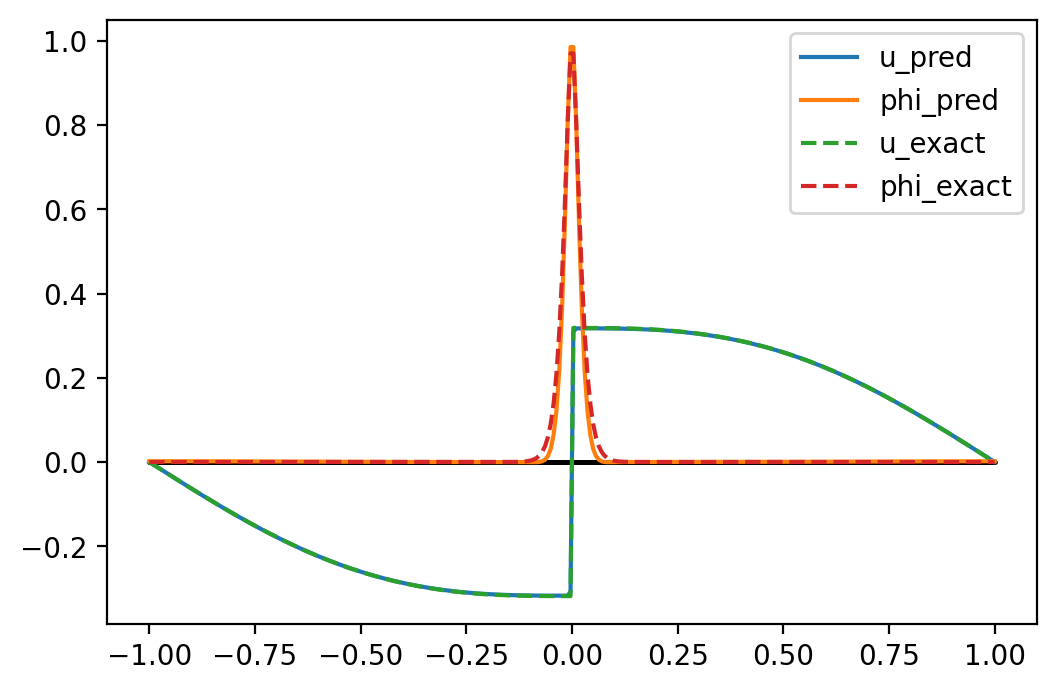

Relative error u: 3.830641e-03
Relative error phi: 1.265056e-01


In [ ]:
import tensorflow as tf
import numpy as np
import time
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
#make figures bigger on HiDPI monitors
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
tf.random.set_seed(42)

class Bar(Geometry1D):
    '''
     Class for definining a 1D domain
     Input: domainEnds - array of the form [x1, x2]
                containing the end points
    '''
    def __init__(self, domainEnds):
      
        # Domain bounds
        self.domainEnds = domainEnds        
        self.x1 = self.domainEnds[0]
        self.x2 = self.domainEnds[1]
        
        geomData = dict()
        # Set degrees
        geomData['degree_u'] = 1
        # Set control points
        geomData['ctrlpts_size_u'] = 2
        
        geomData['ctrlpts'] = [[self.x1, 0.0, 0.0], [self.x2, 0.0, 0.0]]
        
        geomData['weights'] = [1.0, 1.0]
        
        # Set knot vectors
        geomData['knotvector_u'] = [0.0, 0.0, 1.0, 1.0]
        
        super().__init__(geomData)   
 
    
def loading_fun(x):
    '''
    Generate the rhs loading (sinusoidal) for the 1D bar

    Parameters
    ----------
    x : Nx1 array
        input coordinates

    Returns
    -------
    y : Nx1 array
        loading at each point

    '''    
    y = np.sin(np.pi*x)
    return y

def exact_sol(x, l):
    '''
    Exact solution for the 1D bar problem

    Parameters
    ----------
    x : Nx1 array
        input coordinates
        
    l : (scalar)
        scale length parameter for phase field

    Returns
    -------
    u_exact : Nx1 array
              exact displacement
              
    phi_exact : Nx1 array
              exact phi
    

    '''
    
    u_exact = np.sin(np.pi*x)/(np.pi)**2 + np.where(x < 0.0,
                                    -1.0*(1+x)/np.pi, (1-x)/np.pi)
    phi_exact = np.exp(-np.absolute(x-0.)/l)*(1+np.absolute(x-0.)/l)
    
    return u_exact, phi_exact

# Generating points inside the domain using Geometry class
xmin = -1.
xmax = 1.
domainEnds = np.array([-1.0, 1.0])
myLine = Bar(domainEnds)
numElemU = 900
numGauss = 4
xPhys, wgtsPhys, vertex = myLine.getIntPts(numElemU, numGauss)

# Domain bounds
lb = np.array([-1.0])
ub = np.array([1.0])   

data_type = "float64"

#define the input and output data set
Xint = xPhys.astype(data_type)
Yint = loading_fun(Xint).astype(data_type)
plt.scatter(Xint, np.zeros_like(Xint), s=0.5, color='black')

#define the model 
tf.keras.backend.set_floatx(data_type)
l1 = tf.keras.layers.Dense(20, "swish")
l2 = tf.keras.layers.Dense(20, "swish")
l3 = tf.keras.layers.Dense(20, "swish")
l4 = tf.keras.layers.Dense(2, None)

train_op = tf.keras.optimizers.Adam()
num_epoch = 5000
print_epoch = 100

model_data = dict()
model_data['E'] = 1.
model_data['l'] = 0.0125
model_data['B'] = 1000.
model_data['cEnerg'] = 2.7
model_data['crack_loc'] = 0.

pred_model = CalculateUPhi4th([l1, l2, l3, l4], train_op, num_epoch, print_epoch,
                              model_data, data_type)

#convert the training data to tensors
Xint_tf = tf.convert_to_tensor(Xint)
Wint_tf = tf.convert_to_tensor(wgtsPhys.astype(data_type))
Yint_tf = tf.convert_to_tensor(Yint)


t0 = time.time()
print("Training (ADAM)...")

pred_model.network_learn(Xint_tf, Wint_tf, Yint_tf)
t1 = time.time()
print("Time taken (ADAM)", t1-t0, "seconds")

print("Training (TFP-BFGS)...")

loss_func = tfp_function_factory(pred_model, Xint_tf, Wint_tf, Yint_tf)
# convert initial model parameters to a 1D tf.Tensor
init_params = tf.dynamic_stitch(loss_func.idx, pred_model.trainable_variables)
# train the model with BFGS solver
results = tfp.optimizer.bfgs_minimize(
value_and_gradients_function=loss_func, initial_position=init_params,
      max_iterations=1000, tolerance=1e-14)
# after training, the final optimized parameters are still in results.position
# so we have to manually put them back to the model
loss_func.assign_new_model_parameters(results.position)
t2 = time.time()
print("Time taken (BFGS)", t2-t1, "seconds")
print("Time taken (all)", t2-t0, "seconds")


print("Testing...")
numPtsTest = 300
x_test = np.linspace(xmin, xmax, numPtsTest).astype(data_type)
x_test = np.array(x_test)[np.newaxis].T
x_tf = tf.convert_to_tensor(x_test)

u_exact, phi_exact = exact_sol(x_test, model_data['l'])

u_test, phi_test = pred_model.u_phi(x_tf)
plt.plot(x_test, u_test, label = 'u_pred')
plt.plot(x_test, phi_test, label = 'phi_pred')

plt.plot(x_test, u_exact, '--', label = 'u_exact')
plt.plot(x_test, phi_exact, '--', label = 'phi_exact')

plt.legend()
plt.show()

error_u = (np.linalg.norm(u_exact-u_test,2)/np.linalg.norm(u_exact,2))
print('Relative error u: %e' % (error_u))   
error_phi = (np.linalg.norm(phi_exact-phi_test,2)/np.linalg.norm(phi_exact,2))
print('Relative error phi: %e' % (error_phi))

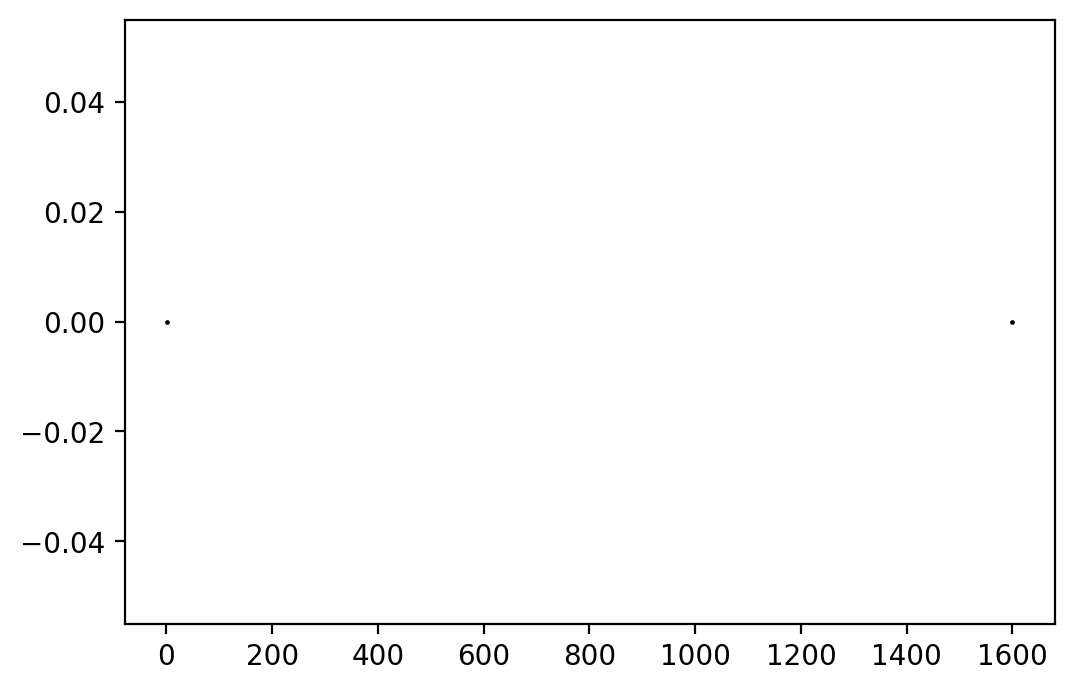

In [ ]:
Xin = (1600,1)
plt.scatter(Xin, np.zeros_like(Xin), s=0.5, color='black')

In [ ]:
xPhys[1800]
# np.where(xPhys== [0.99851113])

array([0.00015429])

In [ ]:
# Xin.shape
arr = np.array([[11, 19, 13, 14, 15, 11, 19, 21, 19, 20, 21]])
np.where(arr == 19)

(array([0, 0, 0]), array([1, 6, 8]))